En este NoteBook se prueba la construcción del perfil con las variables Edad, Género, Tipo de residencia, Frecuencia de recomendación y Frecuencia de realización de actividades.

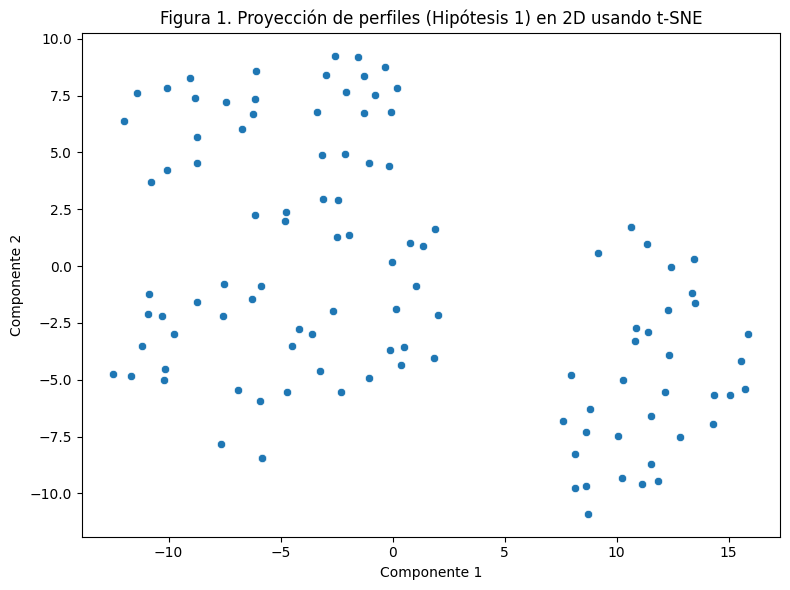

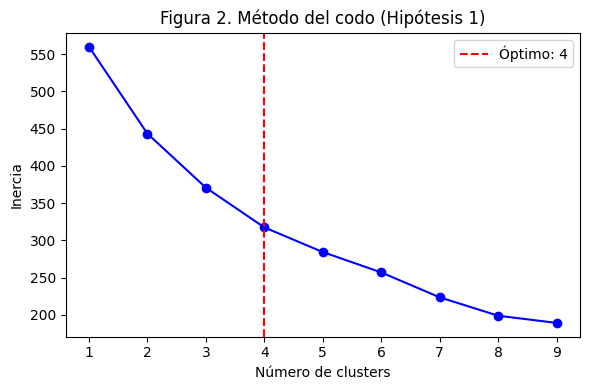

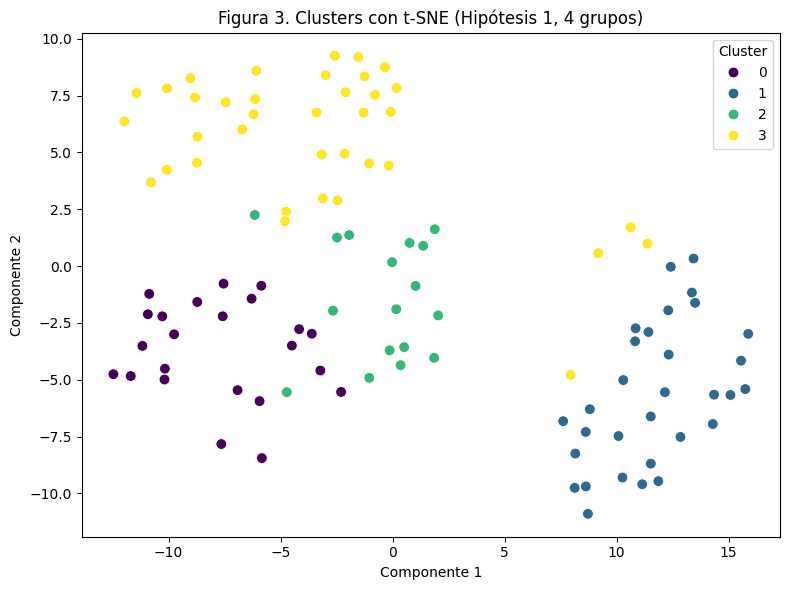

Media del coeficiente por cluster:
cluster
0   -0.017517
1   -0.022589
2   -0.083100
3    0.151112
Name: s_custom, dtype: float64

Media global del coeficiente: 0.031


C:\Users\jorge\AppData\Local\Temp\ipykernel_20016\2253231019.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  valoraciones_binarias = valoraciones.applymap(lambda x: 1 if x >= 4 else 0)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from kneed import KneeLocator

# --- CARGA DE DATOS ---
df = pd.read_excel("respuestas_cuestionario.xlsx")

# --- SELECCIÓN Y CODIFICACIÓN DEL PERFIL ---
perfil_cols = ['edad', 'genero', 'residencia', 'freq_recom', 'actividad_frecuencia']
df_perfil = df[perfil_cols].copy()

# Codificación
df_perfil['genero'] = LabelEncoder().fit_transform(df_perfil['genero'])

orden_residencia = ['No', 'No, pero soy de aquí', 'Solo en verano o en vacaciones', 'Sí, todo el año']
orden_act = ['Solo en fiestas o vacaciones', 'De vez en cuando', 'Varias veces por semana', 'A diario']
encoder_ord = OrdinalEncoder(categories=[orden_residencia, orden_act])
df_perfil[['residencia', 'actividad_frecuencia']] = encoder_ord.fit_transform(df_perfil[['residencia', 'actividad_frecuencia']])

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_perfil)

# --- t-SNE PARA REDUCCIÓN A 2D ---
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# --- FIGURA 1: t-SNE sin clusters ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1])
plt.title("Figura 1. Proyección de perfiles (Hipótesis 1) en 2D usando t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.savefig("figura1_tsne_hip2.png", dpi=300)
plt.show()

# --- ELECCIÓN DEL NÚMERO DE CLUSTERS ---
inertias = []
k_range = range(1, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    inertias.append(km.inertia_)

kneedle = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow

# --- FIGURA 2: Método del codo ---
plt.figure(figsize=(6,4))
plt.plot(k_range, inertias, 'bo-')
plt.axvline(optimal_k, color='red', linestyle='--', label=f"Óptimo: {optimal_k}")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Figura 2. Método del codo (Hipótesis 1)")
plt.legend()
plt.tight_layout()
plt.savefig("figura2_codo_hip2.png", dpi=300)
plt.show()

# --- CLUSTERING Y VISUALIZACIÓN ---
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# --- FIGURA 3: t-SNE coloreado por cluster ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='viridis', s=60)
plt.title(f"Figura 3. Clusters con t-SNE (Hipótesis 1, {optimal_k} grupos)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig("figura3_tsne_clusters_hip2.png", dpi=300)
plt.show()

# --- COEFICIENTE DE SILHOUETTE PERSONALIZADO (MANHATTAN) ---
valor_cols = [col for col in df.columns if col.startswith("valoracion_")]
valoraciones = df[valor_cols].copy()
valoraciones_binarias = valoraciones.applymap(lambda x: 1 if x >= 4 else 0)

X = valoraciones_binarias.values
labels = clusters
n = len(X)

silhouette_vals = []
D = pairwise_distances(X, metric='manhattan')

for i in range(n):
    cluster_i = labels[i]
    in_cluster = [j for j in range(n) if labels[j] == cluster_i and j != i]
    out_cluster = [j for j in range(n) if labels[j] != cluster_i]

    if len(in_cluster) == 0 or len(out_cluster) == 0:
        silhouette_vals.append(np.nan)
        continue

    a_i = np.mean([D[i][j] for j in in_cluster])
    b_i = np.mean([D[i][j] for j in out_cluster])
    s_i = (b_i - a_i) / max(a_i, b_i)
    silhouette_vals.append(s_i)

silhouette_vals = np.array(silhouette_vals)
df_silhouette = pd.DataFrame({
    'indice': range(n),
    'cluster': labels,
    's_custom': silhouette_vals
})

media_por_cluster = df_silhouette.groupby('cluster')['s_custom'].mean()
media_global = np.nanmean(silhouette_vals)

print("Media del coeficiente por cluster:")
print(media_por_cluster)
print("\nMedia global del coeficiente:", round(media_global, 3))